In [78]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 150
import glob, os, json

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

import scipy.stats as st
import timeit
import pickle

# Download HMMER data from the 5 batch jobs using the `03_download_hmmer.py` script

```console
python3 03_download_hmmer.py Data/PFAM_1 495 "https://www.ebi.ac.uk/Tools/hmmer/download/61096978-CBC7-11EC-8F66-6950F75AEC3D."

python3 03_download_hmmer.py Data/PFAM_2 499 "https://www.ebi.ac.uk/Tools/hmmer/download/5E4A7690-CBC8-11EC-AAAC-856C53F04F9B."

python3 03_download_hmmer.py Data/PFAM_3 499 "https://www.ebi.ac.uk/Tools/hmmer/download/9043FFF4-CBC8-11EC-8D6D-2E6C53F04F9B."

python3 03_download_hmmer.py Data/PFAM_4 500 "https://www.ebi.ac.uk/Tools/hmmer/download/07C37B3E-CBCB-11EC-BD7F-D036E976C163."

python3 03_download_hmmer.py Data/PFAM_5 139 "https://www.ebi.ac.uk/Tools/hmmer/download/7636BA96-CBCF-11EC-B1C8-BF6C53F04F9B."
```

# Combine HMMER data for each protein in a batch using `04_process_hmmer.py`

```console
python3 04_process_hmmer.py Data/PFAM_1 Data/proteins_seq_small_1.fasta Data/batch_1

python3 04_process_hmmer.py Data/PFAM_2 Data/proteins_seq_small_2.fasta Data/batch_2

python3 04_process_hmmer.py Data/PFAM_3 Data/proteins_seq_small_3.fasta Data/batch_3

python3 04_process_hmmer.py Data/PFAM_4 Data/proteins_seq_small_4.fasta Data/batch_4

python3 04_process_hmmer.py Data/PFAM_5 Data/proteins_seq_small_5.fasta Data/batch_5
```

# 7 Proteins longer than 5000 had to be queried using their UniProt ID

## Following esults determined manually

Q63HN8: 1 zf-C3HC4, 1 DUF6539

Q09666: 0 (only disordered and low complexity regions)

Q9NU22: 8 AAA_5, 3 AAA_lid_7, 1 AAA_lid_5

P58107: 36 Plectin

Q03001: 2 CH, 20 Spectrin, 1 SH3_10, 1 Spectrin_like, 1 Plectin, 1 EF-hand_7, 1 GAS2

Q86UQ4: 2 ABC2_membrane_3, 2 ABC_tran

Q8NF91: 2 CH, 10 Spectrin, 1 KASH

<b>If a results file is not present in the expected directory, it means that no domains were found.</b>

## Encode them in dataframes as follows (done already and combined with the main dataframe):

In [101]:
# df_1 = pd.DataFrame({'UniProt': ['Q63HN8', 'Q63HN8'], 'PFAM': ['zf-C3HC4', 'DUF6539'], 'Count': [1, 1]})

# df_2 = pd.DataFrame({'UniProt': ['Q9NU22', 'Q9NU22', 'Q9NU22'], 'PFAM': ['AAA_5', 'AAA_lid_7', 'AAA_lid_5'], 'Count': [8, 3, 1]})

# df_3 = pd.DataFrame({'UniProt': ['P58107'], 'PFAM': ['Plectin'], 'Count': [36]})

# df_4 = pd.DataFrame({'UniProt': ['Q03001', 'Q03001', 'Q03001', 'Q03001', 'Q03001', 'Q03001', 'Q03001'], 'PFAM': ['CH', 'Spectrin', 'SH3_10', 'Spectrin_like', 'Plectin', 'EF-hand_7', 'GAS2'], 'Count': [2, 20, 1, 1, 1, 1, 1]})

# df_5 = pd.DataFrame({'UniProt': ['Q86UQ4', 'Q86UQ4'], 'PFAM': ['ABC2_membrane_3', 'ABC_tran'], 'Count': [2, 2]})

# df_6 = pd.DataFrame({'UniProt': ['Q8NF91', 'Q8NF91', 'Q8NF91'], 'PFAM': ['CH', 'Spectrin', 'KASH'], 'Count': [2, 10, 1]})

# files = glob.glob("../Data/batch_*.csv")
# dfs_lst = [pd.read_csv(f) for f in files]

# final = pd.concat([pd.concat(dfs_lst), df_1, df_2, df_3, df_4, df_5, df_6])

# final.to_csv("../Processed/protein_domains.csv", index=False)

In [102]:
df = pd.read_csv("../Processed/protein_domains.csv")
print(df.shape)
print(f"{len(df.UniProt.unique())} proteins")

(5138, 3)
2075 proteins


# Distribution of Protein Domains in the dataset

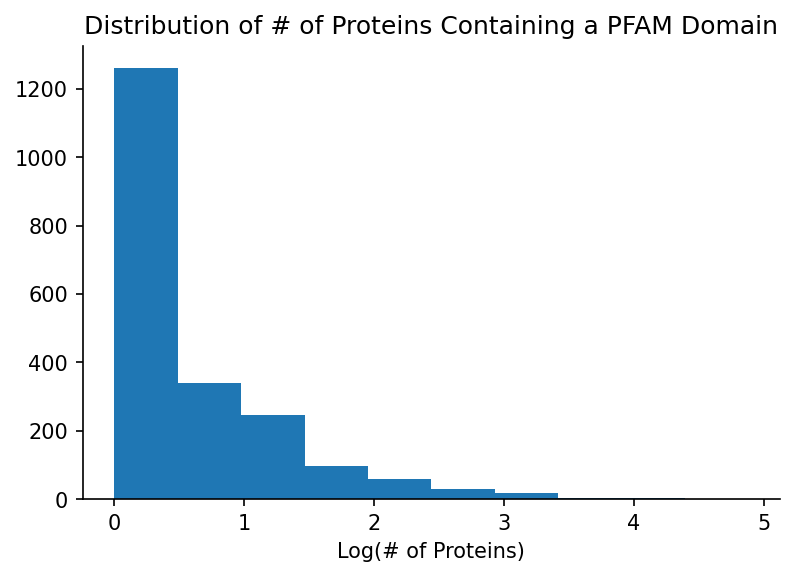

In [103]:
# count the number of proteins containing a given domain
summary_df = pd.DataFrame(df.groupby("PFAM")["UniProt"].count()).sort_values("UniProt", ascending=False).reset_index()
plt.hist(np.log(summary_df["UniProt"]))

plt.title("Distribution of # of Proteins Containing a PFAM Domain")
plt.xlabel("Log(# of Proteins)")
sns.despine()
plt.show()

# Unsupervised Methods

## Principal Components Analysis -- not very informative b/c of such low explained variance and poor clustering

### No significant Spearman correlations between domains and PCs

### Was trying to see if proteins with shared GO functions would cluster together in protein domain space

### Kind of suggestive that's a very weak correlation between sharing GO functions and protein domains

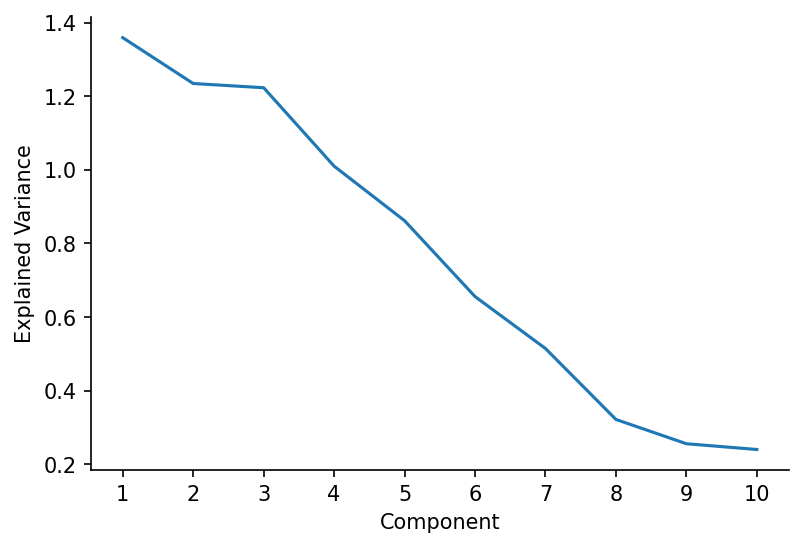

In [105]:
# first check using the elbow method
n = 10

# use the whole matrix for now
data = df.pivot(index="UniProt", columns="PFAM", values="Count").fillna(0).astype(int)

pca_large = PCA(n_components=n).fit(data.values)

plt.plot(np.arange(1, n+1), pca_large.explained_variance_)
sns.despine()
plt.xticks(np.arange(1, n+1))
plt.xlabel("Component")
plt.ylabel("Explained Variance")
plt.show()

In [106]:
# check that no proteins or domains have 0 representation
sum(data.sum(axis=1)==0), sum(data.sum(axis=1)==0)

(0, 0)

Explained variances: [1.35888013 1.2343754 ]


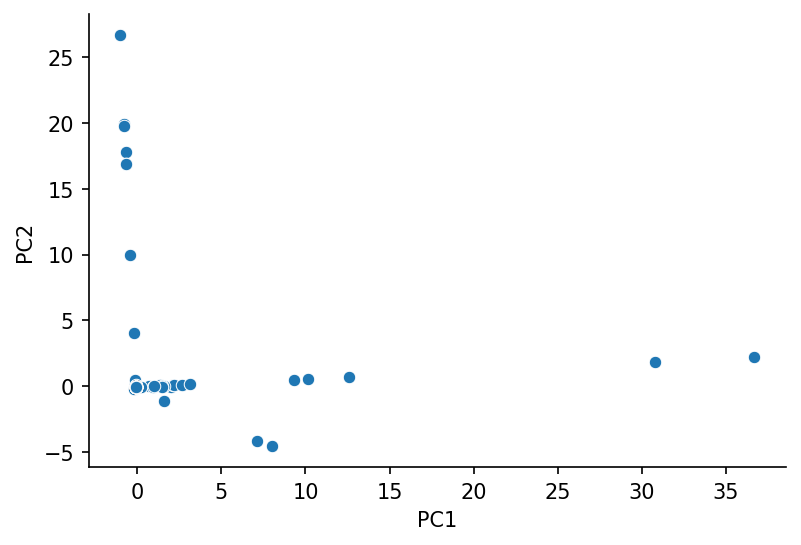

In [107]:
# dbscan = DBSCAN(min_samples=3).fit(matrix_domains_high.values)
# print(f"{np.max(dbscan.labels_)+1} clusters found")

pca = PCA(n_components=2).fit(data.values)

print(f"Explained variances: {pca.explained_variance_}")

pca_transformed = pca.transform(data.values)

pca_df = pd.DataFrame(pca_transformed)

pca_df.columns = ["PC1", "PC2"]

pca_df["UniProt"] = data.index

# -1 cluster means too disordered
#pca_df["Cluster"] = dbscan.labels_

sns.scatterplot(data=pca_df, x="PC1", y="PC2", 
                #hue="Cluster", 
                #palette="viridis"
               )
sns.despine()
plt.show()

In [108]:
spearman_res = [[data.columns[i], st.spearmanr(pca_df.PC1, data.iloc[:, i])] for i in range(n)]

pvalues_pc1, spearman_rhos_pc1 = list(zip(*spearman_res))

In [109]:
for domain, res in spearman_res:
    
    if res[1] < 0.05:
        print(domain, res[0])

# See if proteins that share PFAM domains share GO functions

In [110]:
GO_proteins = pd.read_csv("../Processed/enriched_GO_proteins.csv")
GO_small = GO_proteins.loc[GO_proteins["UniProt"].isin(matrix_domains_high.index)]

# put it in matrix form
matrix_GO = GO_small.pivot(index="Gene", columns="GO")
matrix_GO = matrix_GO.where(~matrix_GO. notna(), 1)
matrix_GO = matrix_GO.fillna(0)

In [111]:
# number of proteins that each GO is associated with
summary_go_df = pd.DataFrame(GO_small.groupby("GO")["Gene"].count()).reset_index().sort_values("Gene", ascending=False).reset_index(drop=True)
summary_go_df.columns = ["GO", "num_proteins"]

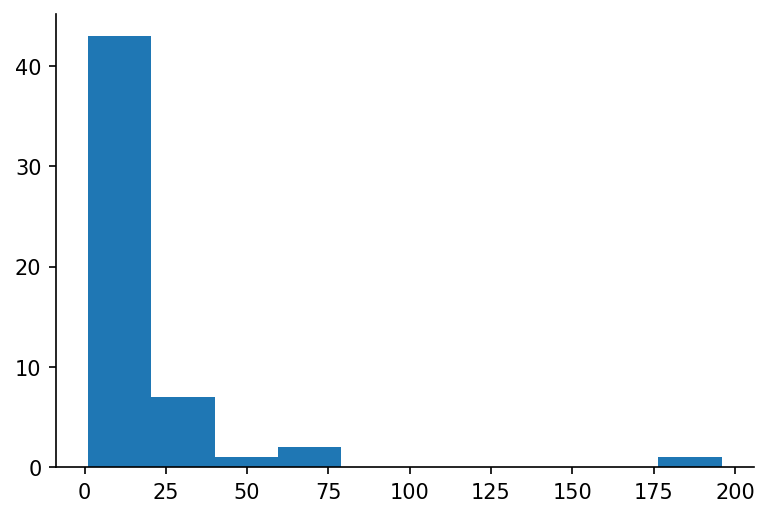

In [112]:
plt.hist(summary_go_df.num_proteins.values)
sns.despine()
plt.show()

In [113]:
# these are the 2229 proteins that were queried on PFAM for their domain
GO_jaccard = pd.read_csv("../Processed/jaccard_non_zero.csv.gz", compression="gzip")

In [114]:
GO_jaccard.shape

(663724, 7)

## For each pair in the above dataframe, compute how many PFAM domains they share

The next cell takes 5-6 minutes to run

In [117]:
# start = timeit.default_timer()

# # this returns the number of rows containing the same PFAM --> means that they have the same domain
# pfam_pairwise_share = [sum(df.loc[df.UniProt.isin([row["uniprot_1"],  row["uniprot_2"]])].duplicated("PFAM")) for _, row in GO_jaccard.iterrows()]

# end = timeit.default_timer()
# print(f"{end-start} seconds")

# # save this for later because it takes a few minutes to run
# with open("../Processed/pfam_pairwise_share", "wb") as file:
#     pickle.dump(pfam_pairwise_share, file, protocol=pickle.HIGHEST_PROTOCOL)

354.57088012500026 seconds


In [127]:
with open('../Processed/pfam_pairwise_share', 'rb') as file:
    pfam_pairwise_share = pickle.load(file)

In [128]:
print(np.mean(pfam_pairwise_share), np.median(pfam_pairwise_share), np.max(pfam_pairwise_share))

0.03487594240979684 0.0 13


In [129]:
len(pfam_pairwise_share), len(GO_jaccard)

(663724, 663724)

In [158]:
test_val = st.spearmanr(GO_jaccard.Jaccard, pfam_pairwise_share)
test_val

SpearmanrResult(correlation=0.046473175543559314, pvalue=0.0)

### Permutation test for the correlation coefficient

p-value = proportion of permutations with an absolute value of the correlation at least as large as the observed one.

In [147]:
#0.2-0.25 seconds to run one iteration

def shuffle_spearman(data_1, data_2):
    
    # keep one array fixed, shuffle the other one
    data_2_shuffled = np.random.permutation(data_2)
    
    # compute the correlation coefficient
    return st.spearmanr(data_1, data_2_shuffled)[0]

In [156]:
# should take 3 minutes and 20 seconds to run
shuffled_corrs = [shuffle_spearman(GO_jaccard.Jaccard, pfam_pairwise_share) for _ in range(1000)]

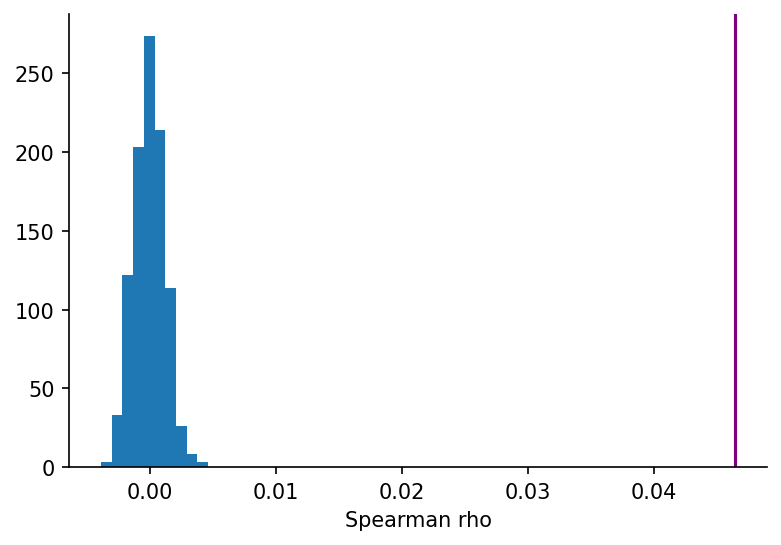

In [162]:
# cool, so it is significant
plt.hist(shuffled_corrs)
sns.despine()
plt.axvline(test_val[0], color="purple")
plt.xlabel("Spearman rho")
plt.show()

In [159]:
# cool, so it is significant, but a very very weak correlation, so it doesn't mean anything probably
p_val = np.sum(np.abs(shuffled_corrs) > np.abs(test_val[0])) / len(shuffled_corrs)
p_val

0.0

In [163]:
test_val[0]

0.046473175543559314

## Need to look further at types of GO functions and see if they're important in i.e. immune defense